<a href="https://colab.research.google.com/github/jopapo/instagram-post-crawler/blob/main/Colab_Instagram_Conti_Motocross.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instala as dependências no servidor da google

# Resumo

Ferramenta de crawling de comentários do instagram (nesse caso dois post específicos) e busca de dados de quem comentou, o comentário e quando.

Depois faz uma análise de cada conjunto de dados de cada post pra extrair os resultados esperados.

## Limitações

Não considera imagens nem replys.

# 1. Preparação do ambiente

Instalação de ferramentas básicas para poder fazer o crawling no instagram.

In [ ]:
!pip install selenium fuzzywuzzy
!apt-get update
!apt install chromium-chromedriver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.3/448.3 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.8 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [633 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,282 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security

Configura um navegador pra rodar em background (Chrome) e simular um usuário

In [ ]:
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--kiosk')
driver = webdriver.Chrome(chrome_options)

Dependências/bibliotecas necessárias à simulação

In [ ]:
import sys, time, csv, pandas as pd

from getpass import getpass

from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

from IPython.display import Image, display, ProgressBar

from fuzzywuzzy import fuzz


Função de apoio pra mostrar imagens do selenium.

In [ ]:
global image_counter
image_counter = 0

def show_browser(element = None):
  global image_counter
  image_counter = image_counter + 1
  driver.save_screenshot(f'temp_{image_counter}.png')
  display(Image(f'temp_{image_counter}.png'))

  if element:
    with open(f'temp_{image_counter}.html', 'w') as f:
      f.write(driver.page_source if element == True else element.get_attribute('innerHtml'))


# Autenticação no instagram

Primeira batida. Precisa logar pra ter o privilégio de navegar nos comentários... mesmo público.
(Aqui não tá 100% ainda, mas quebra um galo)

username:hurrah_
password:··········
Logado


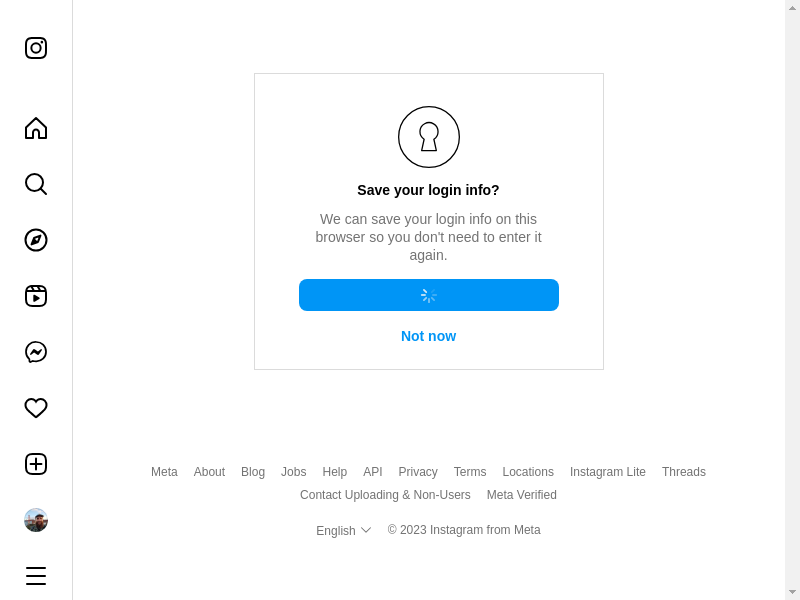

In [ ]:
url="https://www.instagram.com/"

driver.get(url)
time.sleep(2)

try:
  username = WebDriverWait(driver, 10).until(
      EC.presence_of_element_located((By.NAME, "username"))
  )

  allow_cookies = driver.find_elements(By.XPATH, "//*[text()='Allow all cookies']")
  if len(allow_cookies):
    allow_cookies[0].click()

  username.send_keys(input('username:'))

  password = driver.find_element(By.NAME,"password")
  password.send_keys(getpass('password:'))

  password.submit()

  try:
    unusual_login = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, "//*[text()='Send Security Code']"))
    )
    show_browser()
    unusual_login.click() #SMS

    security_code_input = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.ID, "security_code"))
    )
    show_browser()
    security_code_input.send_keys(getpass('security_code'))
    security_code_input.submit()
  except TimeoutException:
    pass

  save_infos = driver.find_elements(By.XPATH, "//*[text()='Save info']")
  if save_infos:
    save_infos[0].click()

  WebDriverWait(driver, 10).until(
      EC.presence_of_element_located((By.CLASS_NAME,"xw7yly9"))
  )

  print('Logado')
  show_browser()

except:
  show_browser(True)
  raise

# Varredura dos posts

Etapa mais longa. Aqui varre o que tem nas variáveis "urls". Esses são os posts a serem avaliados e grava num arquivo "cleanfile_X.csv". Onde X é a posição na lista.

(O formato é CSV... comum)

Ele grava o usuário, comentário e data/hora do comentário (ignora imagens e replys... por enquanto)


In [ ]:
urls = ["https://www.instagram.com/p/C0hO2UCO6KH/", "https://www.instagram.com/p/C0hoEp5p3r_/"]

# Create an empty container to put all the comments inside
fields = ["User", "Text", "Timestamp", "FileIndex"]
filename = f"cleanfile.csv"

with open(filename, 'w',  encoding='utf-8', newline='') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(fields)

# Driver will access to the URL
index = 0
for url in urls:
  index = index + 1
  print('Navegando para:', url)
  driver.get(url)
  time.sleep(10)

  try:
    scroller = WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, '.x5yr21d.xw2csxc.x1odjw0f.x1n2onr6'))
    )

    hasLoadMore = True
    print("Pegando mais páginas de comentários: ", end='')
    scroll_height = None
    count = 0
    while hasLoadMore:
        count = count + 1
        scrollHeight = driver.execute_script("var el = document.querySelector('.x5yr21d.xw2csxc.x1odjw0f.x1n2onr6'); el.scrollTo(0, el.scrollHeight); return el.scrollHeight")
        time.sleep(0.1)
        print(".", end='')
        if not (count % 100):
          print(";")
          driver.save_screenshot(f'scroll_{count}.png')
          #break
        progresbars = driver.find_elements(By.CSS_SELECTOR, '[role=progressbar]')
        if not progresbars:
          print("!")
          break

    print("Varrendo, limpando e gravando os dados...")
    node_list = scroller.find_elements(By.CSS_SELECTOR,'.x78zum5.xdt5ytf.x1iyjqo2')
    pbar_store = ProgressBar(len(node_list))
    with open(filename, 'a',  encoding='utf-8', newline='') as csvfile:
      csvwriter = csv.writer(csvfile)

      for node in node_list:
        pbar_store.progress = pbar_store.progress + 1
        try:
          user_name = node.find_element(By.CSS_SELECTOR,'._ap3a._aaco._aacw._aad7._aade').text
          commentary = node.find_elements(By.CSS_SELECTOR,'.x9f619.xjbqb8w.x78zum5.x168nmei.x13lgxp2.x5pf9jr.xo71vjh.x1uhb9sk.x1plvlek.xryxfnj.x1c4vz4f.x2lah0s.xdt5ytf.xqjyukv.x1cy8zhl.x1oa3qoh.x1nhvcw1')
          timestamps = node.find_elements(By.TAG_NAME, 'time')
          timestamp = timestamps[0].get_attribute('datetime') if len(timestamps) else None
          comment = commentary[0].text if len(commentary) else None
        except:
          print(node.get_attribute('innerHTML'))
          raise

        csvwriter.writerow([user_name, comment, timestamp, index])
    #pbar_store.status = ''

  except:
    driver.save_screenshot('screenie.png')
    raise


print("Fim!")



To: https://www.instagram.com/p/C0hO2UCO6KH/
Search for more: ....................................................................................................;
Traversing, cleaning and storing data...


[============================================================] 17/17

To: https://www.instagram.com/p/C0hoEp5p3r_/
Search for more: ....................................................................................................;
Traversing, cleaning and storing data...


[============================================================] 17/17

Fim!


Lê e mostra o que teve nos posts.

In [ ]:
df = pd.read_csv(r"cleanfile.csv")
display(df)


,User,Text,Timestamp,FileIndex
0,yamaharacingbrasil,NaN,2023-12-06T17:02:40.000Z,1
1,henzo_saviczk1,450🔥,2023-12-06T17:51:54.000Z,1
2,henzo_saviczk1,450🔥,2023-12-06T17:51:54.000Z,1
3,ado_jensen,2t é vida,2023-12-07T09:17:58.000Z,1
4,rodr1c0ronel,YZ 250 2T🔥,2023-12-06T20:12:22.000Z,1
5,claudiodamata,YZ250 2 tempos sempre !!!!!!,2023-12-07T01:25:58.000Z,1
6,bernardosergiodinizvieira,👏E os VETERANOS?👏,2023-12-06T19:40:02.000Z,1
7,carlosmarcelo01,2t sem dúvida!,2023-12-07T10:44:05.000Z,1
8,adrimascarenhas211,Pra divertir 2T pra competir 4T,2023-12-06T19:46:13.000Z,1
9,trilheirosde_verdade,Yz 450f💙,2023-12-06T23:07:26.000Z,1


# Análise dos resultados

Qual você prefere nesta disputa? YZ250 ou YZ450F?

In [ ]:
df1 = df[df.FileIndex == 1].copy() # 1 é o primeiro post da lista

def detect_model(row):
  if isinstance(row.Text, str):
    if '450' in row.Text:
      return '450'
    elif '250' in row.Text:
      return '250'
  return None

# Detecta seleção
df1['Model'] = df1.apply(detect_model, axis = 1)

# Remove duplicatas
df1_uniq = df1[['User','Model']].drop_duplicates()

print('Sumário:')
df1_uniq['Model'].value_counts()

Sumário:


250    6
450    3
Name: Model, dtype: int64

Verificando se a atribuição dos modelos estão corretos:

In [ ]:
display(df1)

Qual piloto você escolhe para usar o colete dourado e ganhar um prêmio especial na Seletiva Final do Yamaha



In [ ]:
# Não sei os instas dos pilotos. Mas tem gente marcando ao invés de escrever o nome, daí deveria estar pro cara correto também.
directs = {
    '@pilotovinisouza': 'Vinícius Pereira Souza'
}

# Nomes possívels que será procurado no texto do comentário por aproximação.
names = ['Alice Farias Matos','Alicia Sagae','Anna Vaz de Lima','Artur Aragão Everton',
         'Benjamin Peralta','Bernardo Lacerda Brag','Caio Costa','Caio Eto Tiburcio',
         'Carlos Andrade','Caua Anibal Batista da Silva','Cauã Santos','Celi Patricio',
         'Clara Coutinho','Cristóbal Manuel Riveros Jeldez','Daniel Tomelin','Enzo Fialho',
         'Enzo Matos Ximenes','Estevão Miranda e Silva','Fabrizio da Silva Souza Filho',
         'Felipe Cartapatti Aoki','Gustavo Akio Honda','Gustavo Lima Moronari da Silva',
         'Helena Oregana','Henri Oliveira Krug','Ignácio Gabriel Brant',
         'Isabelly Vitoria Mombach','João Gabriel Ferreira Vilela',
         'João Pedro Batista Barbosa','Kayque Mendes Pessini',
         'Lorenzo Ritter Grassi','Miguel Garcia','Miguel Glir Pinheiro',
         'Murilo Alves Motta','','Murilo Miwa Bastos','Pedro Lobo','Pedro Miguel Alves',
         'Rheryncher José Heggendorn dos Santos','Salvador Cassini','Samuel Domanski',
         'Samuel Taylor','Santiago Gossa','Santiago Vogel','Valentino Agustín Milone',
         'Vinícius Pereira Souza','Yan Rodrigues Garcia']

df2 = df[df.FileIndex == 2].copy() # 2 é o segundo post da lista

def detect_name(row):
  best_score = 0
  best_name = None
  if isinstance(row.Text, str) and len(row.Text) > 5:
    for key, value in directs.items():
      if key in row.Text:
        return value
    for name in names:
      scored = 0
      all_names = name.split(' ')
      all_words = row.Text.split(' ')
      for unique_name in all_names:
        for unique_word in all_words:
          ratio = fuzz.token_sort_ratio(unique_name, unique_word)
          # Caso a palavra esteja "90%" próxima, pontua como melhor possibilidade.
          if ratio > 90:
            scored = scored + 1
      if scored > best_score:
        best_score = scored
        best_name = name
  return best_name

# Detecta seleção
df2['Name'] = df2.apply(detect_name, axis = 1)

#display(df2)

# Remove duplicatas
df2_uniq = df2[['User','Name']].drop_duplicates()

print('Sumário:')
df2_uniq['Name'].value_counts()


Sumário:


Kayque Mendes Pessini           3
Caua Anibal Batista da Silva    3
Alice Farias Matos              3
                                2
Anna Vaz de Lima                1
Caio Costa                      1
Vinícius Pereira Souza          1
Name: Name, dtype: int64

Verificação se a atribuição do nome está correta:

In [ ]:
display(df2)

,User,Text,Timestamp,FileIndex,Name
17,yamaharacingbrasil,NaN,2023-12-06T20:43:05.000Z,2,None
18,wudyalmeida,Kayque Mendes,2023-12-06T23:23:46.000Z,2,Kayque Mendes Pessini
19,wudyalmeida,Kayque Mendes,2023-12-06T23:23:46.000Z,2,Kayque Mendes Pessini
20,juniorfaiatt,Kayke Mendes Pessini,2023-12-06T23:30:41.000Z,2,Kayque Mendes Pessini
21,bruno.novillo58,Boa sorte pilotooooos 💪🏻💙🫶🏻,2023-12-06T22:53:57.000Z,2,
22,yurysbk,Anna Vaz,2023-12-06T21:25:04.000Z,2,Anna Vaz de Lima
23,alex_schultz_22,Auuuuu ✊️✊️✊️ Boa sorte piloootos 🙌✨️💙,2023-12-06T22:10:18.000Z,2,
24,lenyoliveirasantoss,😍😍😍,2023-12-07T23:17:26.000Z,2,None
25,anibaljotinha,Cauã Aníbal Batista,2023-12-06T21:07:59.000Z,2,Caua Anibal Batista da Silva
26,lenyoliveirasantoss,Alice matos,2023-12-07T23:17:24.000Z,2,Alice Farias Matos
